In [24]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


## Data Preprocessing

In [25]:
# Hyperparameters

# y column normalize scaler
normalizer_constant = 2

# time series step size
time_step = 14

# NN parameters
learning_rate = 0.1
num_epoch = 500
NN_layer_dimension = [100,100]
train_size = 568 # 80% of the data

In [26]:
SNP = pd.read_csv('./SP500.csv')

# get all attributes
SNP_attributes = SNP.iloc[:,2:7]
# get last column (y)
SNP_price = SNP.iloc[:,-1:]

# normalize the data using MinMax scaller
scaler = MinMaxScaler()
scaler.fit(SNP_attributes)
SNP_attributes = scaler.transform(SNP_attributes)

Price_scaler = MinMaxScaler(feature_range=(0,1))
Price_scaler.fit(SNP_price)
SNP_price = Price_scaler.transform(SNP_price)

# scale data to [0,1]
SNP_price = (SNP_price-SNP_price.min())/((SNP_price.max()*normalizer_constant)-SNP_price.min())
SNP_price = np.array(SNP_price)

train_data = SNP_price[0:train_size, :]
train_data_mul = SNP_attributes[0:train_size, :]
# train_data_mul = np.array(train_data_mul)

# univariate
def create_train_data(data):
    x = []
    y = []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i,0])
        y.append(data[i,0])
    return x, y

# multivariate
def create_train_data_mul(data):
    x = []
    y = []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i, 0:data.shape[1]])
        y.append(data[i:i+1,0])
    return x, y

# X_train, y_train = create_train_data(train_data)
X_train, y_train = create_train_data_mul(train_data_mul)

In [27]:
SNP_price.shape

(717, 1)

In [28]:
# Reshaping 
X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [5]:
# NN 
def create_model(units=[12,3], learning_rate=0.3):
    model = tf.keras.models.Sequential()
    # # LSTM RNN model
    model.add(LSTM(units=128,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='tanh'))
    model.add(Dense(1))

    # opt = tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9)
    model.compile(optimizer='adam',loss='mean_squared_error')

    return model

model = create_model(units=NN_layer_dimension, learning_rate=learning_rate)

In [6]:
# Train
model.fit(X_train, y_train, epochs=num_epoch, batch_size=24, verbose=2)

Epoch 1/500
24/24 - 2s - loss: 0.0030 - 2s/epoch - 86ms/step
Epoch 2/500
24/24 - 0s - loss: 3.1864e-04 - 220ms/epoch - 9ms/step
Epoch 3/500
24/24 - 0s - loss: 3.4329e-04 - 223ms/epoch - 9ms/step
Epoch 4/500
24/24 - 0s - loss: 4.0043e-04 - 220ms/epoch - 9ms/step
Epoch 5/500
24/24 - 0s - loss: 3.4251e-04 - 219ms/epoch - 9ms/step
Epoch 6/500
24/24 - 0s - loss: 3.4408e-04 - 230ms/epoch - 10ms/step
Epoch 7/500
24/24 - 0s - loss: 2.8664e-04 - 221ms/epoch - 9ms/step
Epoch 8/500
24/24 - 0s - loss: 6.4567e-04 - 205ms/epoch - 9ms/step
Epoch 9/500
24/24 - 0s - loss: 3.0895e-04 - 205ms/epoch - 9ms/step
Epoch 10/500
24/24 - 0s - loss: 2.7571e-04 - 204ms/epoch - 9ms/step
Epoch 11/500
24/24 - 0s - loss: 2.5168e-04 - 204ms/epoch - 8ms/step
Epoch 12/500
24/24 - 0s - loss: 2.1128e-04 - 208ms/epoch - 9ms/step
Epoch 13/500
24/24 - 0s - loss: 2.1940e-04 - 204ms/epoch - 8ms/step
Epoch 14/500
24/24 - 0s - loss: 2.0665e-04 - 217ms/epoch - 9ms/step
Epoch 15/500
24/24 - 0s - loss: 1.5528e-04 - 221ms/epoch - 9ms

In [7]:
model.save('./NN_model')
#save for flask
model.save_weights('model_weights.h5')
json_string = model.to_json()
f = open("model_architecture.json",'w')
f.write(json_string)
f.close()

INFO:tensorflow:Assets written to: ./NN_model\assets


INFO:tensorflow:Assets written to: ./NN_model\assets


In [8]:
# test data 
test_data = SNP_price[train_size - time_step:, :]
test_data_full = SNP_price[:, :]
test_data_mul = SNP_attributes[train_size - time_step:, :]
test_data_mul_full = SNP_attributes[:, :]

X_test = []
X_test_mul = []
X_test_mul_full = []
X_test_full = []
y_test = SNP_price[train_size:, :]

for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i,0])

for i in range(time_step, len(test_data_mul)):
    X_test_mul.append(test_data_mul[i-time_step:i,0:test_data_mul.shape[1]])

for i in range(time_step, len(test_data_mul_full)):
    X_test_mul_full.append(test_data_mul_full[i-time_step:i,0:test_data_mul_full.shape[1]])

for i in range(time_step, len(test_data_full)):
    X_test_full.append(test_data_full[i-time_step:i,0:test_data_full.shape[1]])


X_test, X_test_mul, X_test_mul_full = np.array(X_test), np.array(X_test_mul), np.array(X_test_mul_full)
X_test_full = np.array(X_test_full,dtype=float)
X_test_full.shape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# # X_test_mul = np.reshape(X_test_mul, (X_test_mul.shape[0], X_test_mul.shape[1], X_test_mul.shape[2]))
# # X_test_mul_full = np.reshape(X_test_mul_full, (X_test_mul_full.shape[0], X_test_mul_full.shape[1], X_test_mul_full.shape[2]))


# X_test_full
X_test_full = np.reshape(X_test_full, (X_test_full.shape[0], X_test_full.shape[1], 1))


In [9]:
predicted_price = model.predict(X_test_full)
# predicted_price_mul = model.predict(X_test_mul)
# predicted_price = Price_scaler.inverse_transform(predicted_price)
# predicted_price = np.repeat(predicted_price,predicted_price.shape[2],axis=-1)
predicted_price = scaler.inverse_transform(predicted_price)[:,0]

# predicted_price = Price_scaler.inverse_transform(predicted_price)[:,0]

# custom inverse transform
# predicted_trans = (predicted_price*SNP_price.max()) - (predicted_price*SNP_price.min()) + SNP_price.min()
predicted_trans = (predicted_price-SNP_price.min())/((SNP_price.max()*normalizer_constant)-SNP_price.min())
# predicted_trans = (predicted_price-SNP_price.min())/((SNP_price.max()*normalizer_constant)-SNP_price.min())
# predicted_trans = np.array(predicted_trans)

# predict_full = model.predict(X_test_mul_full)
# predict_full = np.repeat(predict_full,X_test_mul_full.shape[2], axis=-1)
# predict_full = scaler.inverse_transform(predict_full)[:,0]

ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "sequential_3" (type Sequential).
    
    Input 0 of layer "lstm_4" is incompatible with the layer: expected shape=(None, None, 5), found shape=(None, 14, 1)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 14, 1), dtype=float32)
      • training=False
      • mask=None


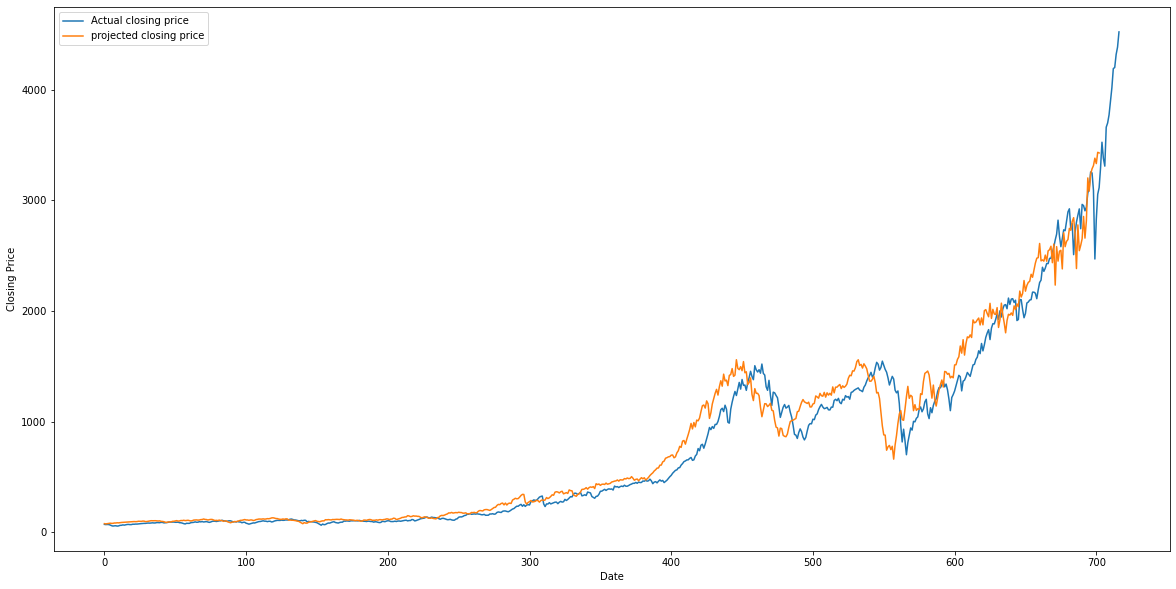

In [10]:
plt.figure(figsize=(20,10))
training = SNP[:]
# valid = SNP[train_size:]
# valid['pred'] = predicted_price_mul
projection = predicted_price

#plot
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(training["Closing Price"], label = 'Actual closing price')
# plt.plot(valid[['Closing Price', 'pred']])
plt.plot(projection, label = 'projected closing price')
plt.legend()
plt.show()


In [ ]:
# number of data points to predict into the future
data_points = 365

# exaclty one time step before the last data point
EDP = len(test_data_full)-time_step

future_data_set = test_data_full

# i = 0

# input = future_data_set[EDP+i:EDP+i+time_step,:]
# input = np.array(input)
# input = np.reshape(input, (input.shape[1], input.shape[0], 1))
# x = model.predict(input)
# x = np.reshape(x,(1,1))
# future_data_set = np.append(future_data_set, x)
# future_data_set = np.reshape(future_data_set, (future_data_set.shape[0], 1))

In [ ]:
for i in range(0, data_points):
    # create the input data 
    # shape should be (1,14,1)
    # it should contain the closing price from month (689+i) to (689+i+14)

    input = future_data_set[EDP+i:EDP+i+time_step,:]
    input = np.array(input)
    input = np.reshape(input, (input.shape[1], input.shape[0], 1))
    
    # predict the (689+i+14+1)th month using the model
    x = model.predict(input)
    
    # append the new prediction back into the dataset
    future_data_set = np.append(future_data_set, x)
    future_data_set = np.reshape(future_data_set, (future_data_set.shape[0], 1))

    # repeat

In [ ]:
# future_data_set = Price_scaler.inverse_transform(future_data_set)[:,0]
future_data_set

array([   70.96      ,    69.26      ,    70.2       , ...,
       -3595.34595301, -3595.34595301, -3595.34595301])

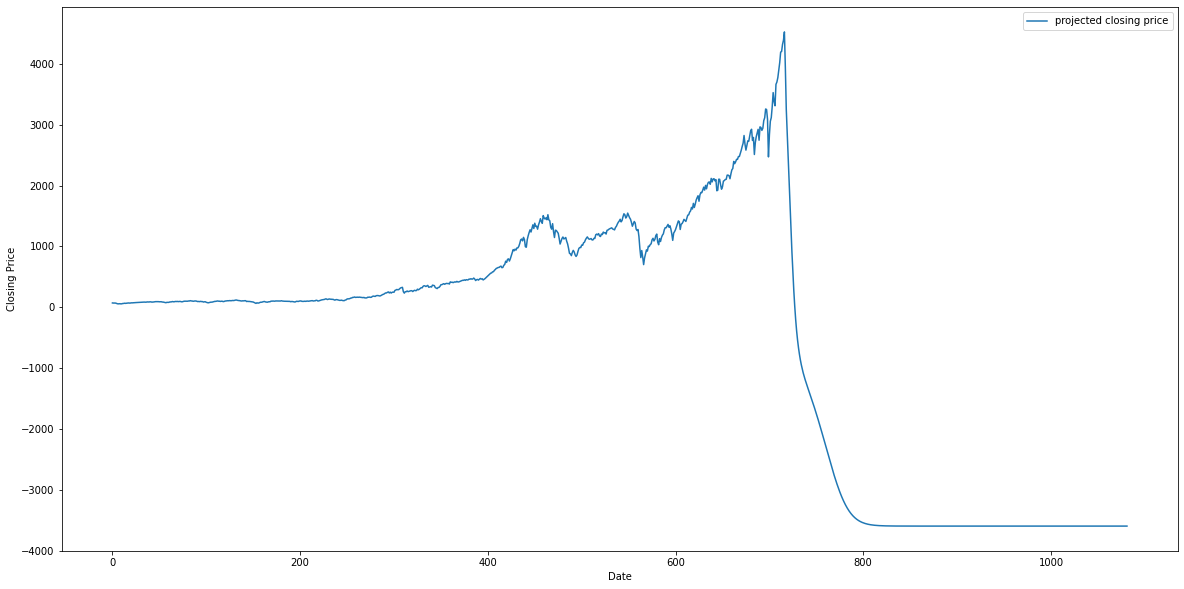

In [ ]:
plt.figure(figsize=(20,10))

#plot
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(future_data_set, label = 'projected closing price')
plt.legend()
plt.show()